In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ORTEC systems:

- Preamplifier: ORTEC 142A, Preamplifier Sensitivity: 45 mV/MeV

- Amplifier: ORTEC 572 A, Set with coarse gain 50 + fine 63, total gain 56.5 

- MCA: Easy MCA, 2048 channels. Main (Ra) peak at channel 984.

- SCA: 550A.

In [2]:
def get_total_gain(dial, coarse_gain = 50):
    Gmin = 0.5
    Gmax = 1.5
    dmin = 0
    dmax = 100
    Gfine = Gmin + (Gmax - Gmin) * (dial - dmin) / (dmax - dmin)
    Gtotal = Gfine * coarse_gain
    return Gtotal

In [3]:
def channel_to_voltage(channel, fine_gain = 63, coarse_gain = 50):
    """
    Convert a channel number to voltage and energy peak.
    :param channel: Channel number (0-2047)
    :param fine_gain: Fine gain setting (0-63)
    :param coarse_gain: Coarse gain setting (default 50)
    :return: Tuple of voltage in mV and energy peak in eV
    """
    if not (0 <= channel < 2048):
        raise ValueError("Channel must be between 0 and 2047")
    
    gain_amp = get_total_gain(fine_gain, coarse_gain)
    gain_preamp = 45 # mV / MeV preamp gain

    V = channel * 10 / 2048 # V
    V_mV = V * 1000 # mV

    E_peak = V_mV / (gain_amp * gain_preamp) # MeV

    print(f"V = {V:.2f} V")
    print(f"E_peak = {E_peak:.2f} MeV")
    return V_mV, E_peak

In [9]:
channel_to_voltage(1530)

V = 7.47 V
E_peak = 2.94 MeV


(7470.703125, 2.9383296460176997)

In [12]:
peak_pos = 984 # channel radium
N = peak_pos # channel radium
claimed_energy = 1793.47 # eV
gain_amp = 56.5 # At Coarse 50, fine 63.

gain_preamp = 45 # mV / MeV preamp gain


V = N * 10 / 2048 # V
V_mV = V * 1000 # mV
E_peak = V_mV / (gain_amp * gain_preamp) # eV

print(f"V = {V:.2f} V")
print(f"E_peak = {E_peak:.2f} eV")

V = 4.80 V
E_peak = 1.89 eV


## For highest peak (Po 212) E = 8.954 MeV

In [20]:
peak_pos = 1530 # channel radium
N = peak_pos # channel radium
claimed_energy = 1793.47 # eV
fine_dial = 54
gain_amp = get_total_gain(fine_dial, coarse_gain = 50) # At Coarse 50, fine 55.

gain_preamp = 45 # mV / MeV preamp gain


V = N * 10 / 2048 # V
V_mV = V * 1000 # mV
E_peak = V_mV / (gain_amp * gain_preamp) # eV

print(f"V = {V:.2f} V")
print(f"E_peak = {E_peak:.2f} eV")

V = 7.47 V
E_peak = 3.19 eV


In [30]:
gain_amp = get_total_gain(63)
N = 1450
V = N * 10 / 2048 # V
V

7.080078125

# Gating the MCA with the SCA:

Using a T-connector to channel the output of the amplifier to both the SCA and the MCA input. The SCA output is then sent to the GATE of the MCA and set to Coincidences.

For Ra224 only, a Lower Level Discriminator (LLD) of 4.9 V is used, and a window or Upper Level Discriminator (ULD) arbitrarily high, 6.4 V

For Th228 only, the LLD is set to 4.62 V with the same window 6.4 V.

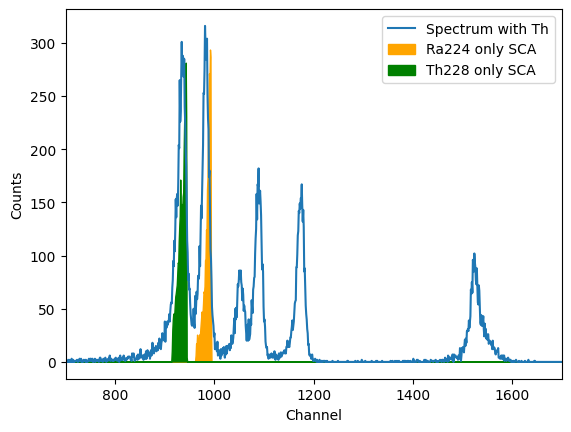

In [3]:
ROOT_PATH = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-pablo.herrero-gomez@mail.huji.ac.il/My Drive/RaTag_data/MCA_spectra'
file_spectrum = ROOT_PATH +'/Second_Th_loaded_detector_in_air2.csv'
df_mca = pd.read_csv(file_spectrum, sep='\t', header=0, skiprows=11, nrows=2048, names=['counts'])
plt.plot(df_mca.counts, label='Spectrum with Th')

file_ra224 = ROOT_PATH +'/Ra224_only_SCA.csv'
df_ra224 = pd.read_csv(file_ra224, sep='\t', header=0, skiprows=11, nrows=2048, names=['counts'])
# plt.plot(df_ra224.counts, label='Ra224 only SCA')
plt.fill_between(df_ra224.index, df_ra224.counts*0.7, color='orange', label='Ra224 only SCA')

file_th228 = ROOT_PATH +'/Th228_only_SCA.csv'
df_th228 = pd.read_csv(file_th228, sep='\t', header=0, skiprows=11, nrows=2048, names=['counts'])
# plt.plot(df_th228.counts, label='Th228 only SCA')
plt.fill_between(df_th228.index, df_th228.counts, color='green', label='Th228 only SCA')

plt.gca().set(xlabel='Channel', ylabel='Counts', xlim=(700, 1700))
plt.legend()

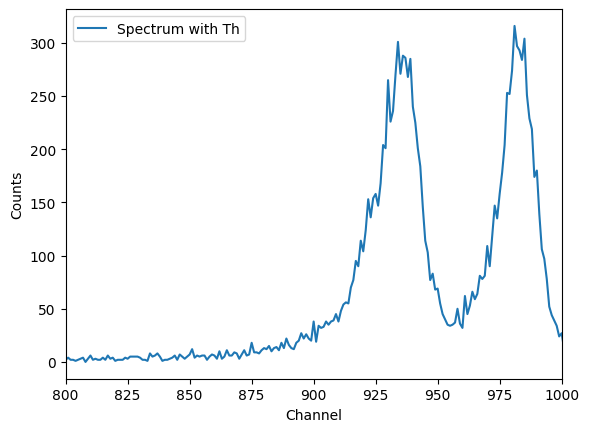

In [5]:
plt.plot(df_mca.counts, label='Spectrum with Th')


plt.gca().set(xlabel='Channel', ylabel='Counts', xlim=(800, 1000))
plt.legend()

# Fit Th 228 peaks

In [10]:
from scipy.stats import crystalball
from scipy.optimize import curve_fit

In [53]:
dff = df_mca[df_ra224['counts'] > 0]

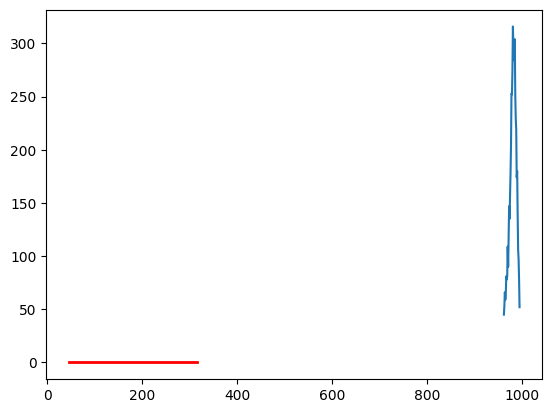

In [54]:
plt.plot(dff.counts, label='Ra224 only SCA')
# plt.gca().set(xlim=(900, 950))
beta, m, loc, scale = crystalball.fit(dff.counts)

cb = crystalball(beta, m, loc=loc, scale=scale)

# plot
x = np.linspace(dff.counts.min(), dff.counts.max(), 500)
plt.plot(x, cb.pdf(x), 'r-', lw=2, label="crystalball PDF")


In [62]:

# 2) build PDF function
def crystalball_pdf(x, beta, m, loc, scale):
    return crystalball.pdf(x, beta, m, loc, scale)

# 3) histogram to get “y” values

# 4) initial guesses: reasonable defaults
x = dff.index.tolist()
x = np.array(x)
p0 = [300.0, 2.0, np.mean(x), np.std(x)]

# 5) fit
popt, pcov = curve_fit(crystalball_pdf, x, dff.counts, p0=p0,
                       bounds=([0, 0, np.min(x), 0],
                               [np.inf, np.inf, np.max(x), np.inf]))

beta, m, loc, scale = popt
print(f"curve_fit → β={beta:.3f}, m={m:.3f}, loc={loc:.3f}, scale={scale:.3f}")

plt.plot(dff.counts, label='MCA')

plt.plot(x, crystalball_pdf(x, *popt), 'r-', label="fit")



RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

# Optimize channel cuts

[Text(0.5, 0, 'Channel'), Text(0, 0.5, 'Counts'), (900.0, 1050.0)]

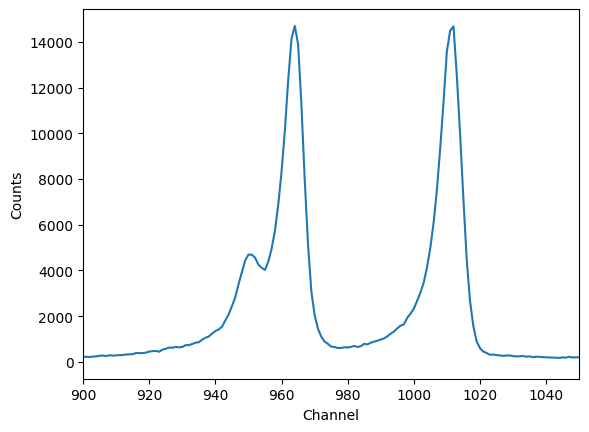

In [16]:
ROOT_PATH = '/Users/pabloherrero/Library/CloudStorage/GoogleDrive-pablo.herrero-gomez@mail.huji.ac.il/My Drive/RaTag_data/MCA_spectra'
file_spectrum = ROOT_PATH +'/Second_Th_loaded_detector_in_air.csv'
df_mca = pd.read_csv(file_spectrum, sep='\t', header=0, skiprows=11, nrows=2048, names=['counts'])
plt.plot(df_mca.counts, label='Spectrum with Th')
plt.gca().set(xlabel='Channel', ylabel='Counts', xlim=(900, 1050))

<Axes: >

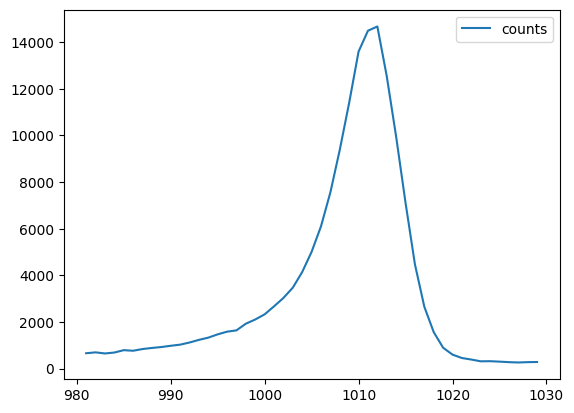

In [26]:
dfdw = df_mca[(df_mca.index > 980)]
dff = dfdw[(dfdw.index < 1030)]
dff.plot()

In [36]:
dff.counts.values

array([  661,   699,   652,   691,   793,   768,   841,   888,   927,
         981,  1029,  1121,  1234,  1330,  1471,  1586,  1642,  1928,
        2108,  2329,  2672,  3032,  3474,  4145,  5009,  6104,  7562,
        9385, 11405, 13598, 14493, 14675, 12544,  9949,  7113,  4474,
        2656,  1566,   898,   602,   456,   391,   315,   320,   301,
         279,   265,   279,   285])

curve_fit → β=100.000, m=20.000, loc=1011.276, scale=1.200


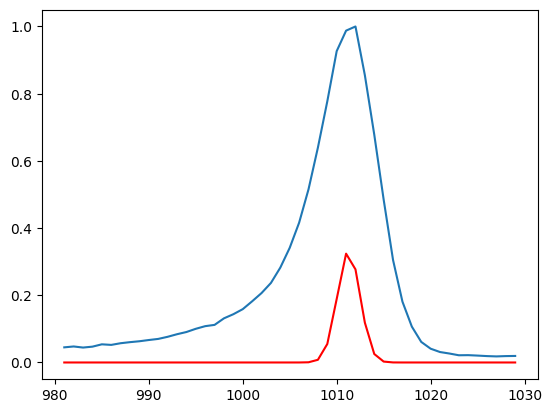

In [ ]:

# 2) build PDF function
def crystalball_pdf(x, A, beta, m, loc, scale):
    return A * crystalball.pdf(x, beta, m, loc, scale)

# 3) histogram to get “y” values

# 4) initial guesses: reasonable defaults
x = dff.index.tolist()
x = np.array(x)

y = dff.counts.values
y = y.astype(float)
y /= np.max(y)  # normalize counts
p0 = [10., 2., 2.0, np.mean(x), np.std(x)]

# 5) fit
popt, pcov = curve_fit(crystalball_pdf, x, y, p0=p0,
                       bounds=([0, 0, 0, np.min(x), 0],
                               [np.inf, np.inf, np.inf, np.max(x), np.inf]))

beta, m, loc, scale = popt
print(f"curve_fit → β={beta:.3f}, m={m:.3f}, loc={loc:.3f}, scale={scale:.3f}")

plt.plot(x, y, label='MCA')

plt.plot(x, crystalball_pdf(x, *popt), 'r-', label="fit")

